Przykład 2
==========
Mamy liczby dziennych wejść na stronę z całego roku. Czy widoczny w nich jest jakiś trend (dane wzrastają/maleją z czasem)? Czy ten trend jest związany z jakimś procesem, czy z losowością danych?

Importujemy biblioteki i wczytujemy dane metodą `np.load`. Rysujemy dane.

In [1]:
%matplotlib inline
import numpy as np
import pylab as py
import scipy.stats as ss

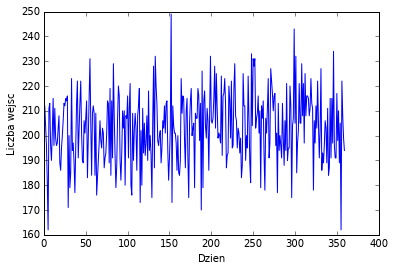

In [2]:
data = np.load("example2_data.npy")
py.plot(data)
py.xlabel("Dzien")
py.ylabel("Liczba wejsc")
py.show()

Do wyznaczenia trendu dopasujemy prostą `y=ax+b` do danych. Dodatnie nachylenie `a` będzie oznaczać wzrost z czasem, ujemne - spadek z czasem. Do regresji posłuży metoda Theila-Sena. Wyznacza ona wielkość `a` jako medianę zbioru nachyleń stworzonego przez dopasowanie prostej do każdej pary punktów. Bardziej dokładnie:
$$a = median(\frac{y[i] - y[j]}{x[i] - x[j]} : i = 1..N, j = 1..N, i\neq j )$$
$$b = median(y) - a \cdot median(x)$$

In [3]:
def theilsen(y, x=None):
    N = len(y)
    if x is None:
        x = np.arange(N)
    a = np.concatenate([(y[:i] - y[i])/(x[:i] - x[i]) for i in range(1, N)])
    return np.median(a)
a = theilsen(data)
b = np.median(data) - a*np.median(np.arange(len(data)))
print(a, b)

0.0162469644177 200.083669887


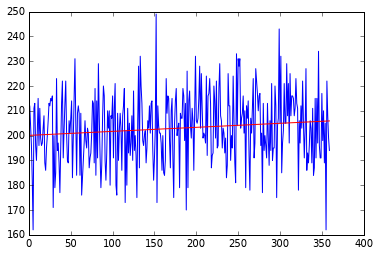

In [4]:
x = np.arange(len(data))
py.plot(data)
py.plot(x, a*x+b, 'r-')

Czyli mamy do czynienia ze wzrostem. Ale czy na pewno? Zawsze dostaniemy albo ujemną albo dodatnią wartość, nawet dla dystrybucji bez trendu (chociaż pewnie będzie ona bardzo mała). Aby sprawdzić, czy nachylenie nie jest spowodowane tylko losowością wyznaczymy jego przedziały ufności. 95% przedział ufności mówi, że dana wielkość, z prawdopodobieństwem 95%, znajdzie się w tym przedziale (podczas następnego eksperymentu). Dodatni/ujemny przedział ufności będzie oznaczać, że rzeczywiście mamy do czynienia ze wzrostem/spadnkiem. Jeśli przedział ufności będzie zawierać 0, to wyznaczona wielkość będzie raczej związana z losowością procesu.

Ponieważ teraz bierzemy losowe wartości z wektora x, musimy upewnić sie, że w algorytmie wyliczającym nachylenie prostej nie dzielimy przez 0. Przepiszmy wcześniejszą funkcję. Rezultat to procedura `slowerTS`. Ma ona jednak tą wadę, że nie korzysta bezpośrednio z numpy, przez co jest wolniejsza ok x10.

In [5]:
def slowerTS(y, x):
    a = []
    N = len(y)
    for i in range(1, N):
        a.extend([(y[i] - y[j])/(x[i] - x[j]) for j in range(i) if x[i] != x[j]])
    return np.median(a)

slopes = np.zeros(1000)
x = np.arange(len(data))
for i in range(1000):
    idx = np.random.randint(0, len(data), size=len(data))
    new_y = data[idx]
    new_x = x[idx]
    slopes[i] = slowerTS(new_y, new_x)
left_ci, right_ci = np.percentile(slopes, [2.5, 97.5])
print(left_ci, right_ci)

0.0 0.0308392751714


Wynik symulacji pokazuje, że przedział ufności jest dodatni. Oznacza to, że prawdopodobnie w naszych danych rzeczywiście jest trend wzrostu.

To samo można uzyskać korzystając z wbudowanej funkcji do liczenia nachyleń

In [6]:
a, b, left_ci, right_ci = ss.theilslopes(data, alpha=0.95)
print(a, b, left_ci, right_ci)

0.0162469644177 200.083669887 0.0 0.030487804878
